# rGreat local vs greatpy

This notebook allows you to compare results between local rGreat and enrichment function from greatpy. 

r-base == 3.6.1

python version == 3.8 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import r as r
pandas2ri.activate()
import pandas as pd

import os 
import matplotlib.pyplot as plt
import greatpy as great 
from scipy.stats import pearsonr
import re
import time 

In [7]:
rpy2.__version__

'3.5.2'

In [3]:
importr('rGREAT')
ranges = importr('GenomicRanges')

In [12]:
def rgreat_online_vs_local_vs_greatpy(): 
    stat_df = {
        "name" : [],
        "pearson_binom" : [], 
        "pearson_hypergeom" : []
    }
    pp = {
        "name" : [],
        "before_pp_greatpy_size" : [], 
        "before_pp_local_size" : [],
        "final_size" : [],
        "%_of_diffrent_GO_term" : [],
    }
    # test_file = ["01_random.bed","06_height_snps_hg38.bed","07_height_snps_hg19.bed","10_MAX.bed"]
    test_file = ["06_height_snps_hg38.bed"]

    for name in test_file : 
        # find the assembly 
        if re.match(".*hg19.*",name) != None : 
            assembly = "hg19"
        else : 
            assembly = "hg38"

        # online test 
        res_online = rpy2.robjects.r['submitGreatJob'](f"../../data/tests/test_data/input/{name}",species=f"{assembly}",help=False)
        res_online = rpy2.robjects.r['getEnrichmentTables'](res_online)

        time.sleep(30)

        # local test
            # proprocessing : make a Grange frame 
        df = r["read.csv"](f"../../data/tests/test_data/input/{name}",sep='\t')
        seqname = rpy2.robjects.StrVector(["seqnames", "seqname","chromosome", "X.Chr","chr", "chromosome_name","seqid"])
        end = rpy2.robjects.StrVector(['end', 'stop'])
        df = ranges.makeGRangesFromDataFrame(df,seqnames_field=seqname)

            # great calculation
        local = rpy2.robjects.r['great'](df, "msigdb:C5", f"txdb:{assembly}",verbose=False)
        local = rpy2.robjects.r['getEnrichmentTables'](local)

        time.sleep(30)

        # greatpy calculation
        greatpy = great.tl.GREAT.enrichment(
            test_file=f"../../data/tests/test_data/input/{name}",
            regdom_file=f"../../data/human/{assembly}/regulatory_domain.bed",
            chr_size_file=f"../../data/human/{assembly}/chr_size.bed",
            annotation_file=f"../../data/human/ontologies.csv",
            binom=True,
            hypergeom=True,
            )

        # create each dataframe
            # online
        name = [cdc.lower() for cdc in list(res_online.rx2("GO Molecular Function").rx2("name"))+list(res_online.rx2("GO Biological Process").rx2("name"))+list(res_online.rx2("GO Cellular Component").rx2("name"))]
        online = pd.DataFrame({
            "id" : list(res_online.rx2("GO Molecular Function").rx2("ID"))+list(res_online.rx2("GO Biological Process").rx2("ID"))+list(res_online.rx2("GO Cellular Component").rx2("ID")),
            "name" : name,
            "binom_p_val" : list(res_online.rx2("GO Molecular Function").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Binom_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Binom_Raw_PValue")),
            "hyper_p_val" : list(res_online.rx2("GO Molecular Function").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Biological Process").rx2("Hyper_Raw_PValue"))+list(res_online.rx2("GO Cellular Component").rx2("Hyper_Raw_PValue"))
            })

            # local
        name_go = list(local.rx2("id")) 
        name_go = [" ".join(cdc.lower().split("_")[1:]) for cdc in list(local.rx2("id"))]
        local = pd.DataFrame({
            "name": name_go,
            "binom_p_val" : list(local.rx2("p_value")),
            "hyper_p_val" : list(local.rx2("p_value_hyper"))
            })

            # greatpy
        greatpy["go_term"] = greatpy["go_term"].str.lower()

        
        time.sleep(90) # just to have not a burning computer ^^ 
        
    return local, online, greatpy

In [13]:
local,online,greatpy = rgreat_online_vs_local_vs_greatpy()

NameError: name 're' is not defined

In [9]:
import pandas as pd
stat = pd.DataFrame({
    "name" : [1,2,3,4],
    "type" : [0,0,1,1],
    "pearson_binom_1" : [0.56,0.45,0.54,0.26],
})

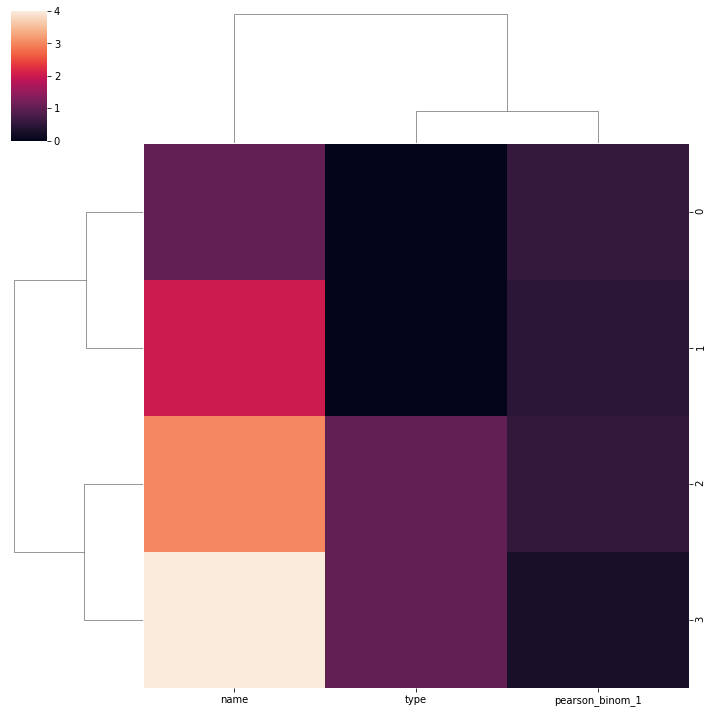

In [10]:
import seaborn as sns 
sns.clustermap(stat)

As we can see the correlation between greatpy and local analysis of rGreat is not good.

In [15]:
preprocess

,name,before_pp_greatpy_size,before_pp_local_size,final_size,%_of_diffrent_GO_term
0,01_random.bed,581,577,47,-1.13617e+03
1,06_height_snps_hg38.bed,2287,1835,367,-5.23160e+02
2,07_height_snps_hg19.bed,2299,1834,369,-5.23040e+02
3,10_MAX.bed,3013,1990,402,-6.49500e+02


As we can see, the shape reduction is very high so It would to say : the GO term pick by the two function is diffrent.